In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sampleSubmission.csv', 'test.csv']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai==1.0.52
import fastai

from fastai import *
from fastai.vision import *
from fastai.tabular import *

# from torchvision.models import *
# import pretrainedmodels

from utils import *
import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

     |████████████████████████████████| 225kB 2.8MB/s 
  Found existing installation: fastai 1.0.55
    Uninstalling fastai-1.0.55:
      Successfully uninstalled fastai-1.0.55


In [3]:
from scipy.special import erfinv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import *
from torch.optim import *
from fastai.tabular import *
import torch.utils.data as Data
from fastai.basics import *
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook as tqdm

In [4]:
def to_gauss(x): return np.sqrt(2)*erfinv(x)  #from scipy

def normalize(data, exclude=None):
    # if not binary, normalize it
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()# list of sorted index
        uniform = np.linspace(start=-0.99, stop=0.99, num=n) # linsapce
        normal = to_gauss(uniform) # apply gauss to linspace
        normalized_col = pd.Series(index=sorted_idx, data=normal) # sorted idx and normalized space
        data[col] = normalized_col # column receives its corresponding rank
    return data

# Data

In [5]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")

In [6]:
df_train.head().T

,0,1,2,3,4
datetime,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00
season,1,1,1,1,1
holiday,0,0,0,0,0
workingday,0,0,0,0,0
weather,1,1,1,1,1
temp,9.84,9.02,9.02,9.84,9.84
atemp,14.395,13.635,13.635,14.395,14.395
humidity,81,80,80,75,75
windspeed,0,0,0,0,0
casual,3,8,5,3,0


In [7]:
df_test.head().T

,0,1,2,3,4
datetime,2011-01-20 00:00:00,2011-01-20 01:00:00,2011-01-20 02:00:00,2011-01-20 03:00:00,2011-01-20 04:00:00
season,1,1,1,1,1
holiday,0,0,0,0,0
workingday,1,1,1,1,1
weather,1,1,1,1,1
temp,10.66,10.66,10.66,10.66,10.66
atemp,11.365,13.635,13.635,12.88,12.88
humidity,56,56,56,56,56
windspeed,26.0027,0,0,11.0014,11.0014


# Data Fields

* datetime - hourly date + timestamp

* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

* holiday - whether the day is considered a holiday

* workingday - whether the day is neither a weekend nor holiday

* weather - 
* 1: Clear, Few clouds, Partly cloudy, Partly cloudy

* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

* temp - temperature in Celsius

* atemp - "feels like" temperature in Celsius

* humidity - relative humidity

* windspeed - wind speed

* casual - number of non-registered user rentals initiated

* registered - number of registered user rentals initiated

* count - number of total rentals

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


In [10]:
add_datepart(df_train, "datetime", drop=False)
add_datepart(df_test, "datetime", drop=False)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetimeYear,...,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeElapsed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,...,20,3,20,False,False,False,False,False,False,1295481600
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,...,20,3,20,False,False,False,False,False,False,1295485200
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,...,20,3,20,False,False,False,False,False,False,1295488800
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,...,20,3,20,False,False,False,False,False,False,1295492400
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,...,20,3,20,False,False,False,False,False,False,1295496000
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,2011,...,20,3,20,False,False,False,False,False,False,1295499600
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,2011,...,20,3,20,False,False,False,False,False,False,1295503200
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013,2011,...,20,3,20,False,False,False,False,False,False,1295506800
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012,2011,...,20,3,20,False,False,False,False,False,False,1295510400
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013,2011,...,20,3,20,False,False,False,False,False,False,1295514000


In [11]:
df_train.head().T

,0,1,2,3,4
datetime,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00
season,1,1,1,1,1
holiday,0,0,0,0,0
workingday,0,0,0,0,0
weather,1,1,1,1,1
temp,9.84,9.02,9.02,9.84,9.84
atemp,14.395,13.635,13.635,14.395,14.395
humidity,81,80,80,75,75
windspeed,0,0,0,0,0
casual,3,8,5,3,0


In [12]:
df_train['season'] = df_train.season.map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df_test['season'] = df_test.season.map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})

df_train['holiday'] = df_train.holiday.map({0: 'non-holiday', 1: 'holiday'})
df_test['holiday'] = df_test.holiday.map({0: 'non-holiday', 1: 'holiday'})

df_train['workingday'] = df_train.workingday.map({0: 'holiday', 1: 'workingday'})
df_test['workingday'] = df_test.workingday.map({0: 'holiday', 1: 'workingday'})

df_train["weather"] = df_train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

df_test["weather"] = df_test.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [13]:
df_train.head().T

,0,1,2,3,4
datetime,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00
season,spring,spring,spring,spring,spring
holiday,non-holiday,non-holiday,non-holiday,non-holiday,non-holiday
workingday,holiday,holiday,holiday,holiday,holiday
weather,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...
temp,9.84,9.02,9.02,9.84,9.84
atemp,14.395,13.635,13.635,14.395,14.395
humidity,81,80,80,75,75
windspeed,0,0,0,0,0
casual,3,8,5,3,0


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 25 columns):
datetime                    10886 non-null datetime64[ns]
season                      10886 non-null object
holiday                     10886 non-null object
workingday                  10886 non-null object
weather                     10886 non-null object
temp                        10886 non-null float64
atemp                       10886 non-null float64
humidity                    10886 non-null int64
windspeed                   10886 non-null float64
casual                      10886 non-null int64
registered                  10886 non-null int64
count                       10886 non-null int64
datetimeYear                10886 non-null int64
datetimeMonth               10886 non-null int64
datetimeWeek                10886 non-null int64
datetimeDay                 10886 non-null int64
datetimeDayofweek           10886 non-null int64
datetimeDayofyear           10886 non-n

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 22 columns):
datetime                    6493 non-null datetime64[ns]
season                      6493 non-null object
holiday                     6493 non-null object
workingday                  6493 non-null object
weather                     6493 non-null object
temp                        6493 non-null float64
atemp                       6493 non-null float64
humidity                    6493 non-null int64
windspeed                   6493 non-null float64
datetimeYear                6493 non-null int64
datetimeMonth               6493 non-null int64
datetimeWeek                6493 non-null int64
datetimeDay                 6493 non-null int64
datetimeDayofweek           6493 non-null int64
datetimeDayofyear           6493 non-null int64
datetimeIs_month_end        6493 non-null bool
datetimeIs_month_start      6493 non-null bool
datetimeIs_quarter_end      6493 non-null bool
datetimeIs_qu

# Fastai - Tabular

In [16]:
procs=[FillMissing, Categorify]

cat_vars = ['season', 'holiday', 'workingday', 'weather', 'datetimeYear', 'datetimeMonth',
           'datetimeWeek', 'datetimeDay', 'datetimeDayofweek']

cont_vars = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']

dep_var = 'count'

In [17]:
df_train.head().T

,0,1,2,3,4
datetime,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00
season,spring,spring,spring,spring,spring
holiday,non-holiday,non-holiday,non-holiday,non-holiday,non-holiday
workingday,holiday,holiday,holiday,holiday,holiday
weather,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...
temp,9.84,9.02,9.02,9.84,9.84
atemp,14.395,13.635,13.635,14.395,14.395
humidity,81,80,80,75,75
windspeed,0,0,0,0,0
casual,3,8,5,3,0


In [18]:
df_train = normalize(df_train, exclude=['season', 'holiday', 'workingday', 'weather', 'datetimeYear', 'datetimeMonth',
           'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'count', 'datetime'])

In [19]:
df_train.head().T

,0,1,2,3,4
datetime,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00
season,spring,spring,spring,spring,spring
holiday,non-holiday,non-holiday,non-holiday,non-holiday,non-holiday
workingday,holiday,holiday,holiday,holiday,holiday
weather,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...
temp,-1.23698,-1.33605,-1.33661,-1.22386,-1.22338
atemp,-0.968703,-1.04045,-1.04084,-0.919921,-0.919225
humidity,0.812104,0.773704,0.777399,0.544257,0.54505
windspeed,-2.57583,-1.15495,-1.16703,-1.16568,-1.16299
casual,-0.81147,-0.336471,-0.529511,-0.736412,-1.39031


In [20]:
df = df_train[cat_vars + cont_vars + [dep_var,'datetime']].copy()
df.head().T

,0,1,2,3,4
season,spring,spring,spring,spring,spring
holiday,non-holiday,non-holiday,non-holiday,non-holiday,non-holiday
workingday,holiday,holiday,holiday,holiday,holiday
weather,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...,Clear + Few clouds + Partly cloudy + Partly c...
datetimeYear,2011,2011,2011,2011,2011
datetimeMonth,1,1,1,1,1
datetimeWeek,52,52,52,52,52
datetimeDay,1,1,1,1,1
datetimeDayofweek,5,5,5,5,5
temp,-1.23698,-1.33605,-1.33661,-1.22386,-1.22338


In [21]:
df_train['datetime'].min(), df_train['datetime'].max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [22]:
df_test['datetime'].min(), df_test['datetime'].max()

(Timestamp('2011-01-20 00:00:00'), Timestamp('2012-12-31 23:00:00'))

In [23]:
len(df_test), len(df_train)

(6493, 10886)

In [24]:
path = Path("../input/")

In [25]:
np.random.seed(42)

data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch(bs=1024))

In [26]:
data.show_batch()

season,holiday,workingday,weather,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,temp,atemp,humidity,windspeed,casual,registered,target
fall,non-holiday,workingday,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",2011,7,27,6,2,0.8112,0.9051,1.0268,-1.1435,-1.3909,-1.3152,6.0
spring,non-holiday,workingday,Clear + Few clouds + Partly cloudy + Partly cloudy,2012,2,6,9,3,-0.6876,-0.6497,-1.5811,-0.1576,-0.1199,1.4380,417.0
summer,non-holiday,workingday,"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",2011,4,13,1,4,-1.2875,-1.3939,1.6290,0.2642,-0.9064,-0.7839,28.0
winter,non-holiday,holiday,Clear + Few clouds + Partly cloudy + Partly cloudy,2012,12,50,15,5,-0.3473,-0.3785,-0.5311,-0.4757,1.1634,1.1532,413.0
winter,non-holiday,workingday,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",2012,10,40,2,1,0.1701,0.2072,1.3109,0.0215,-1.1430,-1.5500,5.0


In [27]:
learn = tabular_learner(data, layers=[1000,500], metrics=mean_squared_error, model_dir="../temp/model",
                        ps=[0.1, 0.1], emb_drop=0.04)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


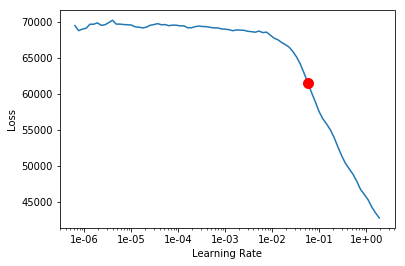

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [29]:
lr = 1e-1
learn.fit_one_cycle(5, max_lr=lr, wd=0.2, pct_start=0.3)

epoch,train_loss,valid_loss,mean_squared_error,time
0,64363.589844,85253.648438,85253.648438,00:00
1,40011.101562,79323.328125,79323.328125,00:00
2,25588.447266,6796.081543,6796.081543,00:00
3,17922.199219,2521.383789,2521.383789,00:00
4,13174.992188,766.045532,766.045532,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


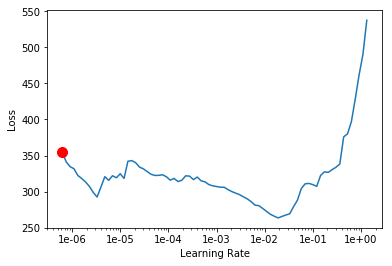

In [30]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [31]:
lr = 1e-4
learn.fit_one_cycle(5, lr, wd=0.2, pct_start=0.3)

epoch,train_loss,valid_loss,mean_squared_error,time
0,294.090851,285.792358,285.792358,00:00
1,302.689026,173.506363,173.506363,00:00
2,298.098785,156.621536,156.621536,00:00
3,289.700195,157.609589,157.609589,00:00
4,300.868347,193.864487,193.864487,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


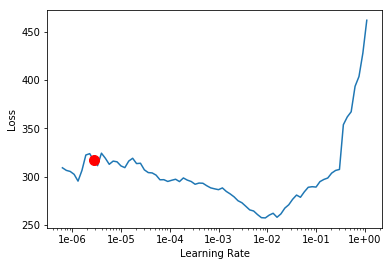

In [32]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [33]:
lr=5e-6
learn.fit_one_cycle(5, max_lr=lr, wd=0.2)

epoch,train_loss,valid_loss,mean_squared_error,time
0,341.808075,199.626099,199.626099,00:00
1,309.863708,201.960464,201.960464,00:00
2,308.475433,216.407043,216.407043,00:01
3,309.759155,218.979553,218.979553,00:01
4,301.939026,213.168137,213.168137,00:00


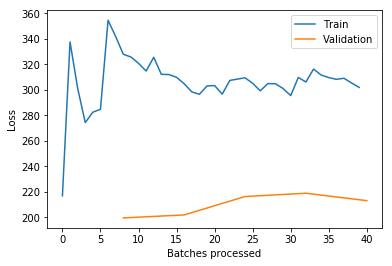

In [34]:
learn.save('1')
learn.recorder.plot_losses()

# Fastai Hooks

In [35]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [36]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(5, 4)
    (4): Embedding(3, 3)
    (5): Embedding(13, 7)
    (6): Embedding(47, 14)
    (7): Embedding(20, 9)
    (8): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=58, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [37]:
sf = SaveFeatures(learn.model.layers[4])

In [38]:
_= learn.get_preds(data.train_ds)

In [39]:
label = [x for x in (list(data.train_ds.y.items))]

In [40]:
len(label)

8709

In [41]:
df_new = pd.DataFrame({'label': label})

In [42]:
df_new.head()

,label
0,40.0
1,32.0
2,1.0
3,1.0
4,2.0


In [43]:
array = np.array(sf.features)

In [44]:
x=array.tolist()

In [45]:
df_new['img_repr'] = x

In [46]:
df_new.head()

,label,img_repr
0,40.0,"[92.00924682617188, -62.026344299316406, -2.76..."
1,32.0,"[93.86600494384766, -66.47396850585938, -5.736..."
2,1.0,"[104.68399047851562, -106.0104751586914, -34.5..."
3,1.0,"[105.0588607788086, -107.30105590820312, -35.5..."
4,2.0,"[104.95793151855469, -109.93849182128906, -37...."


In [47]:
d2 = pd.DataFrame(df_new.img_repr.values.tolist(), index = df_new.index).rename(columns = lambda x: 'img_repr{}'.format(x+1))

In [48]:
df_new_2 = df_new.join(d2)

In [49]:
df_new_2.head(10).T

,0,1,2,3,4,5,6,7,8,9
label,40,32,1,1,2,3,14,56,84,94
img_repr,"[92.00924682617188, -62.026344299316406, -2.76...","[93.86600494384766, -66.47396850585938, -5.736...","[104.68399047851562, -106.0104751586914, -34.5...","[105.0588607788086, -107.30105590820312, -35.5...","[104.95793151855469, -109.93849182128906, -37....","[103.64703369140625, -99.3145751953125, -29.16...","[100.63005828857422, -83.68910217285156, -16.1...","[90.27729034423828, -57.14949035644531, 1.6838...","[84.92039489746094, -45.69585418701172, 8.1767...","[84.0654067993164, -45.513633728027344, 8.4036..."
img_repr1,92.0092,93.866,104.684,105.059,104.958,103.647,100.63,90.2773,84.9204,84.0654
img_repr2,-62.0263,-66.474,-106.01,-107.301,-109.938,-99.3146,-83.6891,-57.1495,-45.6959,-45.5136
img_repr3,-2.76877,-5.73633,-34.5134,-35.5138,-37.7919,-29.1606,-16.1253,1.68382,8.17673,8.40362
img_repr4,58.6181,60.0724,68.4521,68.9774,68.5278,67.5966,65.1501,57.0149,53.1622,52.7223
img_repr5,-32.9067,-35.291,-56.1812,-56.9698,-58.1319,-52.5848,-43.8366,-29.8324,-24.0389,-23.6845
img_repr6,48.3312,49.4888,57.3625,57.7392,57.7454,56.3697,53.7377,46.9796,43.8926,43.5399
img_repr7,-98.304,-100.7,-114.175,-114.536,-114.708,-112.811,-108.883,-95.7817,-88.7318,-87.5076
img_repr8,59.1752,61.384,77.8166,78.5622,79.0441,75.3797,69.1364,56.4792,51.0268,50.5013


In [50]:
df_new_2.shape


(8709, 502)

# Embeddings for Valid Data

In [51]:
sf = SaveFeatures(learn.model.layers[4])

In [52]:
_=learn.get_preds(DatasetType.Valid)

In [53]:
label = [x for x in (list(data.valid_ds.y.items))]

In [54]:
df_new_valid = pd.DataFrame({'label': label})


In [55]:
array = np.array(sf.features)

In [56]:
x=array.tolist()


In [57]:
df_new_valid['img_repr'] = x


In [58]:
df_new_valid.head()

,label,img_repr
0,127.0,"[72.67230224609375, -29.236703872680664, 15.03..."
1,13.0,"[99.04598999023438, -86.20266723632812, -21.36..."
2,163.0,"[64.59049987792969, -13.327085494995117, 15.23..."
3,233.0,"[58.993804931640625, 6.153583526611328, 33.657..."
4,222.0,"[60.930686950683594, 6.949336051940918, 34.242..."


In [59]:
d2 = pd.DataFrame(df_new_valid.img_repr.values.tolist(), index = df_new_valid.index).rename(columns = lambda x: 'img_repr{}'.format(x+1))

In [60]:
df_new_valid_2 = df_new_valid.join(d2)


In [61]:
df_new_valid_2.head(10)

,label,img_repr,img_repr1,img_repr2,img_repr3,img_repr4,img_repr5,img_repr6,img_repr7,img_repr8,...,img_repr491,img_repr492,img_repr493,img_repr494,img_repr495,img_repr496,img_repr497,img_repr498,img_repr499,img_repr500
0,127.0,"[72.67230224609375, -29.236703872680664, 15.03...",72.672302,-29.236704,15.035087,45.627144,-16.123274,38.296913,-74.852646,41.937519,...,6.642655,56.209690,-49.860939,-2.648411,13.778158,35.865391,33.743530,-31.003923,61.385780,46.145439
1,13.0,"[99.04598999023438, -86.20266723632812, -21.36...",99.045990,-86.202667,-21.364803,65.096146,-45.310776,54.056564,-107.501732,70.059921,...,-36.004902,105.846558,-77.686096,-57.675461,-21.396564,55.065380,55.512222,-57.793648,78.714249,87.161697
2,163.0,"[64.59049987792969, -13.327085494995117, 15.23...",64.590500,-13.327085,15.234292,40.093201,-6.929288,33.516846,-60.455208,35.023228,...,10.365061,44.108635,-38.017807,4.347594,16.025934,29.779509,28.637627,-21.315063,57.637375,36.216141
3,233.0,"[58.993804931640625, 6.153583526611328, 33.657...",58.993805,6.153584,33.657471,35.202850,2.676905,29.314442,-53.475426,25.893608,...,29.334190,26.852942,-31.022125,27.276276,32.755459,23.878597,21.367304,-13.214138,53.855652,21.119366
4,222.0,"[60.930686950683594, 6.949336051940918, 34.242...",60.930687,6.949336,34.242714,36.429436,2.492191,30.121296,-55.367847,26.951584,...,28.972637,26.448387,-32.412720,27.623039,32.853439,24.250778,22.274303,-14.011950,55.851562,20.905273
5,166.0,"[67.1596450805664, -11.395580291748047, 22.272...",67.159645,-11.395580,22.272472,41.412189,-6.629396,34.481972,-63.506546,35.079903,...,15.921179,41.518707,-40.327114,10.006607,22.775749,29.956600,28.497219,-21.961475,60.116734,33.688812
6,144.0,"[68.89483642578125, -22.210193634033203, 13.98...",68.894836,-22.210194,13.987085,43.964722,-13.503359,36.797691,-69.338181,39.704742,...,6.738476,50.120274,-46.001396,-1.149014,13.762257,33.699516,32.325043,-27.730381,59.605949,41.119865
7,376.0,"[26.09621238708496, 29.928972244262695, 41.360...",26.096212,29.928972,41.360153,16.681627,20.200142,13.719000,-20.369148,5.352510,...,43.137703,-1.828730,-3.486703,44.892197,41.103203,7.447663,5.514220,6.903601,34.374237,-1.486713
8,601.0,"[7.890498161315918, 113.43572998046875, 72.729...",7.890498,113.435730,72.729378,-0.976310,54.407349,-0.397810,29.060669,-21.964737,...,80.798035,-64.361855,31.388672,104.365326,74.608032,-12.093304,-15.977621,38.688438,21.203327,-54.715866
9,53.0,"[90.0463638305664, -57.873870849609375, -0.328...",90.046364,-57.873871,-0.328924,57.260822,-30.911882,47.169449,-95.657372,57.229141,...,-12.451803,81.727081,-67.012741,-28.250536,0.629595,46.132332,45.792397,-45.515213,73.001091,67.115547


In [62]:
df_new_valid_2.shape

(2177, 502)

In [63]:
df_new_valid_2.drop(['img_repr'], axis=1, inplace=True)

In [64]:
df_new_valid_2.head()

,label,img_repr1,img_repr2,img_repr3,img_repr4,img_repr5,img_repr6,img_repr7,img_repr8,img_repr9,...,img_repr491,img_repr492,img_repr493,img_repr494,img_repr495,img_repr496,img_repr497,img_repr498,img_repr499,img_repr500
0,127.0,72.672302,-29.236704,15.035087,45.627144,-16.123274,38.296913,-74.852646,41.937519,-67.179138,...,6.642655,56.209690,-49.860939,-2.648411,13.778158,35.865391,33.743530,-31.003923,61.385780,46.145439
1,13.0,99.045990,-86.202667,-21.364803,65.096146,-45.310776,54.056564,-107.501732,70.059921,-98.153252,...,-36.004902,105.846558,-77.686096,-57.675461,-21.396564,55.065380,55.512222,-57.793648,78.714249,87.161697
2,163.0,64.590500,-13.327085,15.234292,40.093201,-6.929288,33.516846,-60.455208,35.023228,-53.842480,...,10.365061,44.108635,-38.017807,4.347594,16.025934,29.779509,28.637627,-21.315063,57.637375,36.216141
3,233.0,58.993805,6.153584,33.657471,35.202850,2.676905,29.314442,-53.475426,25.893608,-46.429974,...,29.334190,26.852942,-31.022125,27.276276,32.755459,23.878597,21.367304,-13.214138,53.855652,21.119366
4,222.0,60.930687,6.949336,34.242714,36.429436,2.492191,30.121296,-55.367847,26.951584,-47.985916,...,28.972637,26.448387,-32.412720,27.623039,32.853439,24.250778,22.274303,-14.011950,55.851562,20.905273


# Random Forest

In [65]:
df_new_2.drop(['img_repr'], axis=1, inplace=True)

In [66]:
df_new_2.shape

(8709, 501)

In [67]:
df_new_2.describe()

,label,img_repr1,img_repr2,img_repr3,img_repr4,img_repr5,img_repr6,img_repr7,img_repr8,img_repr9,...,img_repr491,img_repr492,img_repr493,img_repr494,img_repr495,img_repr496,img_repr497,img_repr498,img_repr499,img_repr500
count,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,...,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000,8709.000000
mean,191.590194,65.865177,-14.014961,19.309448,40.932215,-8.087510,34.026147,-62.667298,35.317019,-55.571588,...,12.692903,43.462810,-39.993252,6.680514,18.538795,30.233742,28.736588,-22.797823,58.407908,35.364771
std,181.001035,30.303222,63.353220,32.524020,21.257775,32.575243,17.656326,42.867575,30.146504,40.433580,...,39.637820,55.386325,35.293554,53.031828,32.494942,22.170956,23.323737,31.382656,18.043720,45.802450
min,1.000000,-67.979599,-121.526642,-47.837982,-55.233765,-64.452789,-43.686394,-118.142365,-93.120140,-108.876663,...,-67.011368,-196.359833,-88.794167,-94.620834,-54.994339,-64.966232,-73.601410,-73.019165,-30.881168,-168.672562
25%,43.000000,47.946640,-64.558678,-5.659547,27.845718,-33.788475,23.248945,-97.312042,16.231396,-88.178230,...,-18.012314,8.920535,-68.316109,-35.170723,-5.831994,16.544611,13.946182,-47.797401,47.917702,6.530401
50%,145.000000,71.423080,-22.588795,17.703821,44.507050,-12.445396,37.062912,-71.664032,39.612450,-63.700672,...,10.046979,51.227814,-46.744873,2.151499,17.258064,33.692482,32.117390,-27.732317,61.540619,41.811321
75%,285.000000,90.480072,26.428539,40.608257,58.333076,12.513525,48.351395,-38.047340,59.696884,-32.168221,...,38.820957,87.941048,-19.270512,41.528206,40.026817,48.135574,47.562042,-3.147676,73.175766,72.321701
max,970.000000,108.601532,266.848480,163.437195,71.086838,131.434296,59.580154,138.307587,82.731506,129.060181,...,178.190521,133.325699,118.369789,231.456146,148.181671,63.757950,65.667267,110.844208,83.198608,108.698418


In [68]:
corr_matrix = df_new_2.corr()

corr_matrix["label"].sort_values(ascending = False)

label          1.000000
img_repr123    0.996295
img_repr169    0.995966
img_repr382    0.995963
img_repr406    0.995857
img_repr378    0.995670
img_repr263    0.995630
img_repr198    0.995580
img_repr7      0.995573
img_repr38     0.995422
img_repr490    0.995206
img_repr354    0.995114
img_repr369    0.995056
img_repr131    0.995053
img_repr9      0.995019
img_repr105    0.994907
img_repr404    0.994857
img_repr405    0.994843
img_repr276    0.994756
img_repr319    0.994662
img_repr100    0.994586
img_repr147    0.994582
img_repr493    0.994570
img_repr386    0.994490
img_repr17     0.994400
img_repr426    0.994376
img_repr120    0.994322
img_repr465    0.994311
img_repr370    0.994105
img_repr398    0.993939
                 ...   
img_repr449   -0.992916
img_repr62    -0.992959
img_repr14    -0.992966
img_repr348   -0.992969
img_repr432   -0.992997
img_repr220   -0.993042
img_repr246   -0.993049
img_repr58    -0.993074
img_repr364   -0.993079
img_repr360   -0.993131
img_repr306   -0

In [69]:
X = df_new_2
y = df_new_2.label.copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [70]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6967, 501), (6967,), (1742, 501), (1742,))

In [71]:
X_train = X_train.drop("label", axis =1)
y_train = y_train

X_test = X_test.drop("label", axis =1)
y_test = y_test

In [72]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6967, 500), (6967,), (1742, 500), (1742,))

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes_names].values

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numerical pipeline

num_pipeline = Pipeline([
    
    ('select_data', DataFrameSelector(X_train.columns)),
    ('Std_Scaler', StandardScaler())
])

X_train_transformed = num_pipeline.fit_transform(X_train)
X_test_transformed = num_pipeline.fit_transform(X_test)

In [75]:
X_train_transformed.shape, X_test_transformed.shape

((6967, 500), (1742, 500))

In [76]:
from sklearn.ensemble import RandomForestRegressor
import time

start = time.time()

rf_clf = RandomForestRegressor(bootstrap=True,
            criterion='mse', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=185, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

rf_clf.fit(X_train_transformed, y_train)

end = time.time()

print("run_time:", (end-start)/(60*60))

run_time: 0.044216604431470234


In [77]:
# import scipy.stats as st
# from sklearn.model_selection import RandomizedSearchCV

# one_to_left = st.beta(10, 1)  
# from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(50, 300),
#     "max_depth": st.randint(3, 40),
#    "min_samples_leaf": st.randint(3, 40),
#     "min_samples_split": st.randint(3, 20),
#     "max_features": ['auto', 0.2, 0.3, 0.5]
# }

# gs = RandomizedSearchCV(rf_clf, params)

In [78]:
# gs.fit(X_train_transformed, y_train)  

In [79]:
# gs.best_params_

# Prediction

In [80]:
from sklearn.model_selection import cross_val_predict, cross_val_score

import time

start = time.time()

score_rf = cross_val_score(rf_clf, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error', verbose=0)
print(score_rf.mean())

end = time.time()

print("run_time:", (end-start)/(60*60))

-51.69098132374675
run_time: 0.16677108003033533


In [81]:
y_pred_test_rf = rf_clf.predict(X_test_transformed)

In [82]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test_rf)

95.82978428799605

In [83]:
X = df_new_valid_2
y = df_new_valid_2.label.copy()

In [84]:
X_val = X.drop("label", axis =1)
y_val = y

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numerical pipeline

num_pipeline = Pipeline([
    
    ('select_data', DataFrameSelector(X_val.columns)),
    ('Std_Scaler', StandardScaler())
])


X_val_transformed = num_pipeline.fit_transform(X_val)

In [86]:
y_pred_test_rf_val = rf_clf.predict(X_val_transformed)

In [87]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_val, y_pred_test_rf_val)

58.32590691696146